In [1]:
include(joinpath(@__DIR__, "..", "..", "utils", "plot_utils.jl"))

overlay_posterior_on_observed (generic function with 1 method)

## Part 1

In [18]:
using CSV, DataFrames

# from your data-prep cell
df = CSV.read("../../case_study_2/python/data/total_cells.csv", DataFrame)

times    = df[end-14:end, :1]
y_obs    = df[end-14:end, :2] * 1e6

nothing

In [19]:
function ode(du, u, p, t)
    P = u[1]

    r = p[1]
    K = p[2]

    du[1] = r * (1 - P / K) * P

    return nothing
end

ode (generic function with 1 method)

In [20]:
using Turing
@model function fit_ode(log_y_obs, times, prob)
    r ~ Uniform(0.5, 1.0)
    K ~ Uniform(1e6, 4e7)

    P0 ~ Uniform(1e5, 3e5)
    
    sigma ~ truncated(Normal(0, 3), 0, Inf)

    # solve exactly at data times
    sol = solve(prob, Tsit5();
                u0 = [P0], p = [r, K], 
                #tspan = (times[1], times[end]), ## can reset this if need be, but don't have to.
                saveat = times)

    # likelihood at observation times
    log_y_pred = log.(Array(sol)[1, :] .+ 1e-9)
    log_y_obs ~ arraydist(Normal.(log_y_pred, sigma))
end

fit_ode (generic function with 4 methods)

In [21]:
using DifferentialEquations

u0 = [y_obs[1]]
p = [0.5, 1e6]
tspan = (times[1], times[end])
prob = ODEProblem(ode, u0, tspan, p)

log_y_obs = log.(y_obs .+ 1e-9)
model    = fit_ode(log_y_obs, times, prob)
chain    = sample(model, NUTS(1000, .95), MCMCSerial(), 1000, 3; progress=false)

┌ Info: Found initial step size
│   ϵ = 0.8
└ @ Turing.Inference C:\Users\Whisk\.julia\packages\Turing\Avpxw\src\mcmc\hmc.jl:215
┌ Info: Found initial step size
│   ϵ = 0.4
└ @ Turing.Inference C:\Users\Whisk\.julia\packages\Turing\Avpxw\src\mcmc\hmc.jl:215
┌ Info: Found initial step size
│   ϵ = 0.8
└ @ Turing.Inference C:\Users\Whisk\.julia\packages\Turing\Avpxw\src\mcmc\hmc.jl:215


Chains MCMC chain (1000×18×3 Array{Float64, 3}):

Iterations        = 1001:1:2000
Number of chains  = 3
Samples per chain = 1000
Wall duration     = 2.54 seconds
Compute duration  = 2.49 seconds
parameters        = r, K, P0, sigma
internals         = n_steps, is_accept, acceptance_rate, log_density, hamiltonian_energy, hamiltonian_energy_error, max_hamiltonian_energy_error, tree_depth, numerical_error, step_size, nom_step_size, lp, logprior, loglikelihood

Use `describe(chains)` for summary statistics and quantiles.


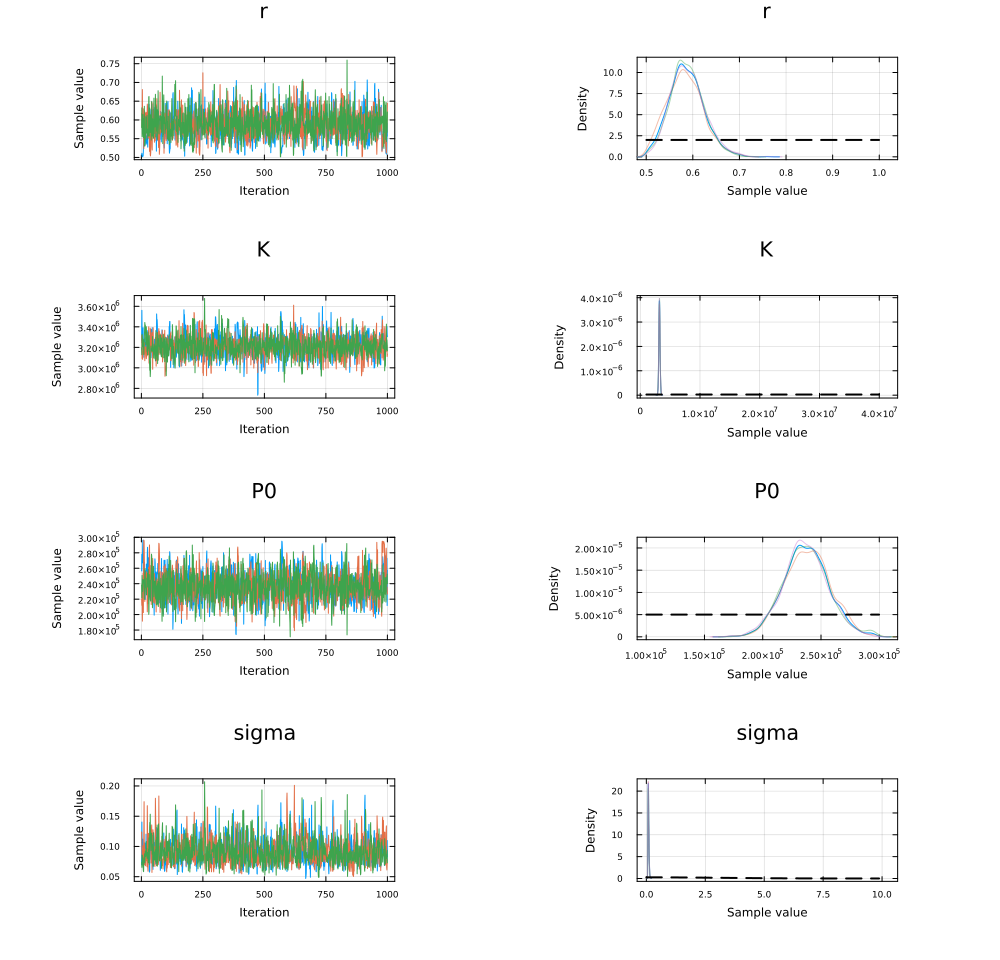

In [22]:
priors = Dict{Symbol,Distribution}(
    :r     => Uniform(0.5, 1.0),
    :K     => Uniform(1e6, 4e7),
    :P0    => Uniform(1e5, 3e5),
    :sigma => truncated(Normal(0, 3), 0, Inf),
)

order = [:r, :K, :P0, :sigma]
plot_trace_with_priors(chain; priors=priors, var_order=order, per_chain_density=true)  # also per-chain densities

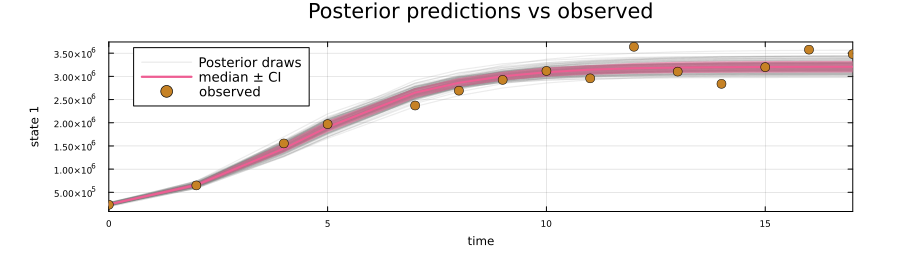

In [23]:
init_syms = [:P0]
param_syms = [:r, :K]
t_obs = times
y_obs = y_obs

plt = overlay_posterior_on_observed(
    chain, ode, t_obs, y_obs;
    init_syms=init_syms,
    param_syms=param_syms,
    which_states=[1],     # choose states to plot
    n_draws=150,            # how many posterior paths to overlay
    plot_ribbon=true,       # median ± CI band
    legend=:topleft,
    ribbon_q=(0.1, 0.9),    # CI limits
    logy=false
)
display(plt)

## Part 2

In [8]:
using CSV, DataFrames

# from your data-prep cell
cells = CSV.read("../../case_study_2/python/data/total_cells.csv", DataFrame)
death = CSV.read("../../case_study_2/python/data/death_percentage.csv", DataFrame)

cells_times  = cells[end-14:end, :1]
cells_obs    = cells[end-14:end, :2] * 1e6

death_times = death[1:15, :1]
death_obs   = death[1:15, :2] .* (cells_obs ./ 100)

nothing

In [9]:
function ode(du, u, p, t)
    P = u[1]
    D = u[2]

    r = p[1]
    K = p[2]
    delta = p[3]

    du[1] = r * (1 - P / K) * P - delta * P
    du[2] = delta * P

    return nothing
end

ode (generic function with 1 method)

In [10]:
using Turing

@model function fit_ode(logP_obs, logD_obs, times, prob)
    r ~ Uniform(0.5, 1.0)
    K ~ Uniform(1e6, 4e7)
    delta ~ Uniform(0.0, 0.15)

    P0 ~ Uniform(1e5, 3e5)
    D0 ~ Uniform(1e4, 7e4)

    sigma_live ~ truncated(Normal(0, 3), 0, Inf)
    sigma_dead ~ truncated(Normal(0, 3), 0, Inf)
    
    # solve exactly at data times
    sol = solve(prob, Tsit5();
                u0 = [P0, D0], p = [r, K, delta], 
                #tspan = (times[1], times[end]), ## don't need to reset this every time. but you can if need be.
                saveat = times)
    S = Array(sol) 

    logP_pred = log.((S[1, :] + S[2, :]) .+ 1e-9) # total!! since that's what's done in PyMC
    logD_pred = log.(S[2, :] .+ 1e-9)

    logP_obs ~ arraydist(Normal.(logP_pred, sigma_live))
    logD_obs ~ arraydist(Normal.(logD_pred, sigma_dead))

end

fit_ode (generic function with 4 methods)

In [11]:
using DifferentialEquations

u0 = [cells_obs[1], death_obs[1]]
p = [0.5, 1e6, 0.0] # i'm picking the bottom end of the priors
tspan = (cells_times[1], cells_times[end])
prob = ODEProblem(ode, u0, tspan, p)

log_cells_obs = log.(cells_obs .+ 1e-9)
log_death_obs = log.(death_obs .+ 1e-9)
model    = fit_ode(log_cells_obs, log_death_obs, cells_times, prob)
chain    = sample(model, NUTS(1000, .95), MCMCSerial(), 1000, 3; progress=false)
 

┌ Info: Found initial step size
│   ϵ = 0.8
└ @ Turing.Inference C:\Users\Whisk\.julia\packages\Turing\Avpxw\src\mcmc\hmc.jl:215
┌ Info: Found initial step size
│   ϵ = 0.2
└ @ Turing.Inference C:\Users\Whisk\.julia\packages\Turing\Avpxw\src\mcmc\hmc.jl:215
┌ Info: Found initial step size
│   ϵ = 0.05
└ @ Turing.Inference C:\Users\Whisk\.julia\packages\Turing\Avpxw\src\mcmc\hmc.jl:215


Chains MCMC chain (1000×21×3 Array{Float64, 3}):

Iterations        = 1001:1:2000
Number of chains  = 3
Samples per chain = 1000
Wall duration     = 11.93 seconds
Compute duration  = 10.92 seconds
parameters        = r, K, delta, P0, D0, sigma_live, sigma_dead
internals         = n_steps, is_accept, acceptance_rate, log_density, hamiltonian_energy, hamiltonian_energy_error, max_hamiltonian_energy_error, tree_depth, numerical_error, step_size, nom_step_size, lp, logprior, loglikelihood

Use `describe(chains)` for summary statistics and quantiles.


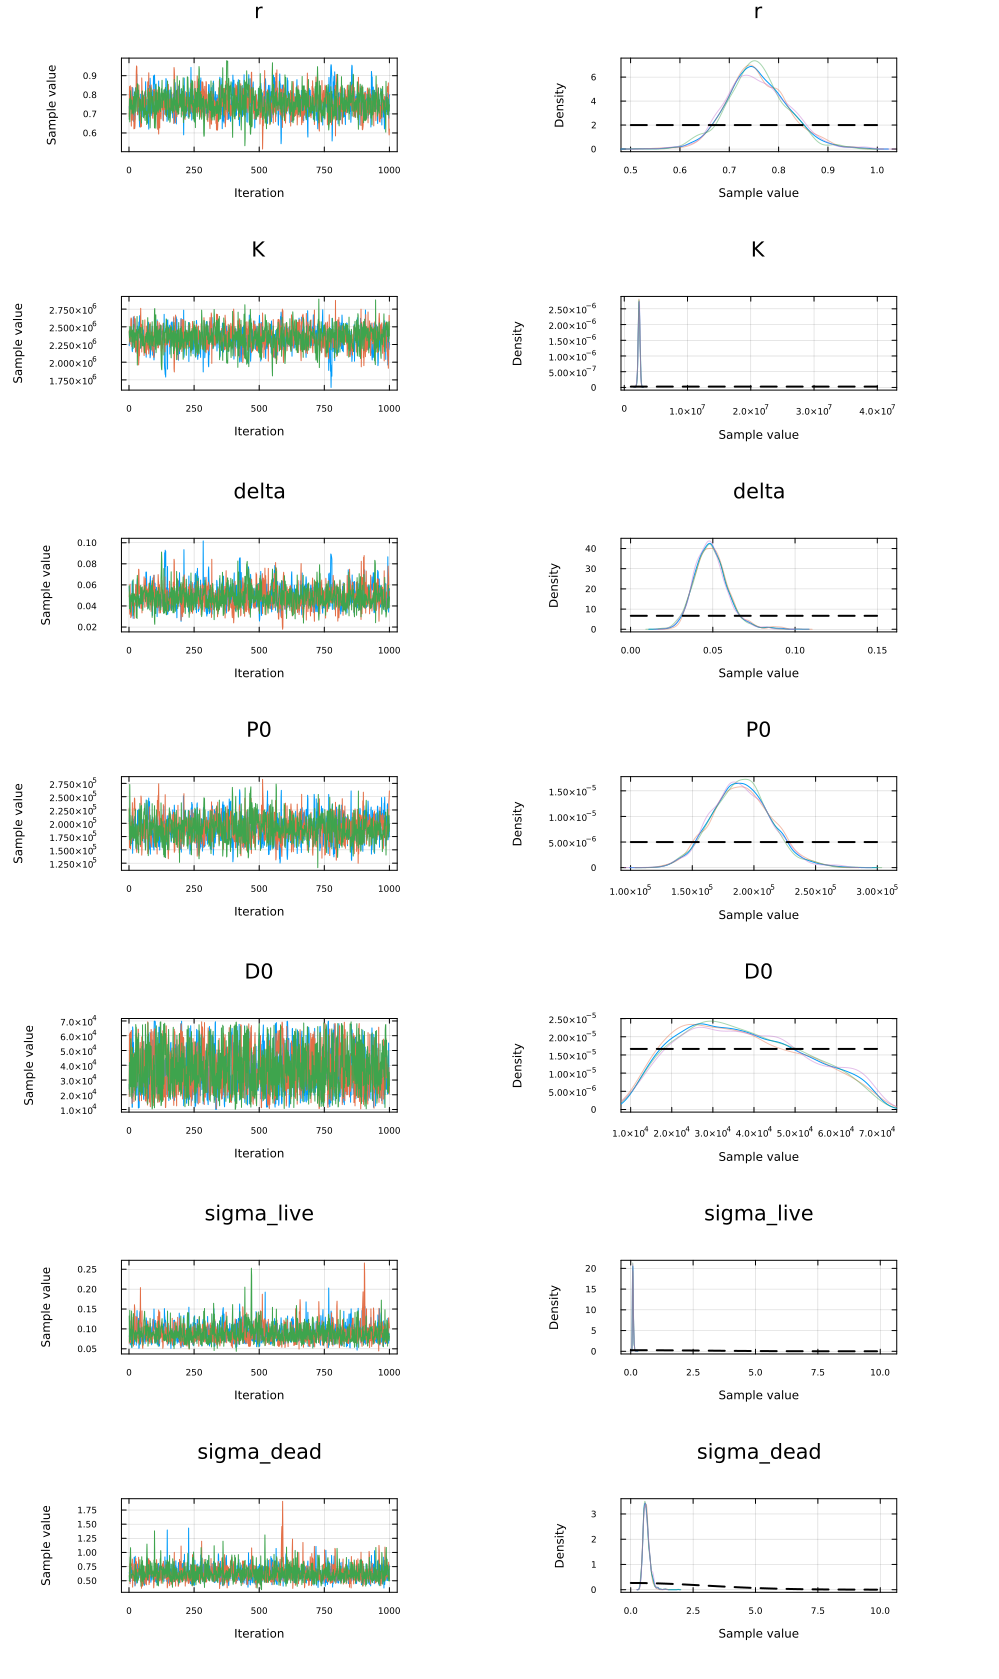

In [17]:
priors = Dict{Symbol,Distribution}(
    :r     => Uniform(0.5, 1.0),
    :K     => Uniform(1e6, 4e7),
    :delta => Uniform(0.0, 0.15),
    :P0    => Uniform(1e5, 3e5),
    :D0    => Uniform(1e4, 7e4),
    :sigma_live => truncated(Normal(0, 3), 0, Inf),
    :sigma_dead => truncated(Normal(0, 3), 0, Inf)
)

order = [:r, :K, :delta, :P0, :D0, :sigma_live, :sigma_dead]

plot_trace_with_priors(chain; priors=priors, var_order=order, per_chain_density=true)  # also per-chain densities

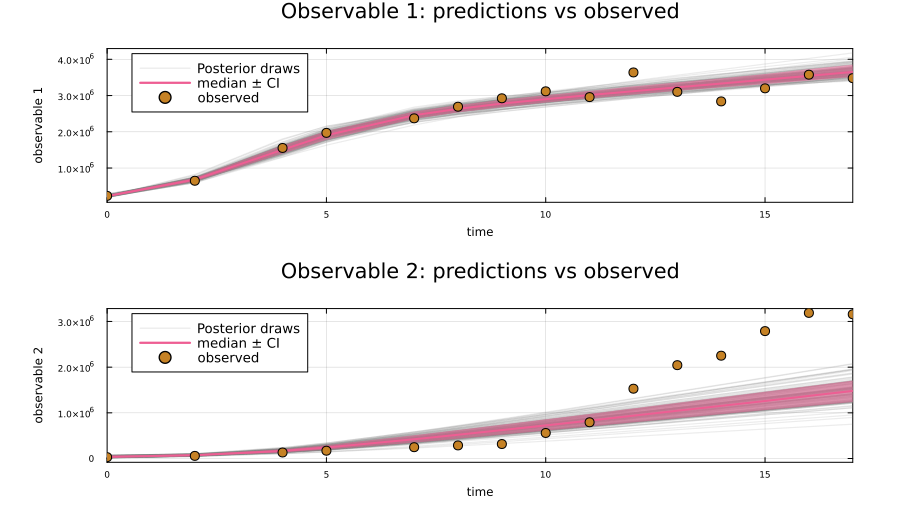

In [13]:
init_syms = [:P0, :D0]
param_syms = [:r, :K, :delta]
t_obs = cells_times
y_obs = hcat(cells_obs, death_obs)

plt = overlay_posterior_on_observed(
    chain, ode, t_obs, y_obs;
    init_syms=init_syms,
    param_syms=param_syms,
    which_states=[1, 2],     # choose states to plot
    pred_transforms=[u -> u[1] + u[2], u -> u[2]], # column1=total(P+D), column2=dead(D)
    legend=:topleft,
    n_draws=150,            # how many posterior paths to overlay
    plot_ribbon=true,       # median ± CI band
    ribbon_q=(0.1, 0.9),    # CI limits
    logy=false
)
display(plt)